In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
np.random.seed(24)
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')


In [3]:
def plotit(df, show=True, resized=False):
    
    if resized:
        df = df.groupby(['x1','x2','y']).count().reset_index().rename(columns={'weights':'sizes'})
        sizes = ((df.sizes.values - (df.sizes.min())+0.9) ** 3) * 100
    else:
        sizes = [250 for x in range(len(df))]
        
    markers = ['+' if y==1 else 'o' for y in df.y]
    colors = ['r' if y==1 else 'b' for y in df.y]
    facecolors=['r' if y==1 else 'none' for y in df.y]

    
    
    fig = plt.figure(figsize=(15,8))
    for pos,row in enumerate(df.values):
        plt.scatter(row[0], row[1], marker=markers[pos], color=colors[pos], facecolors=facecolors[pos], s=sizes[pos], lw=3)
        plt.xticks([-1, 0, 1])
        plt.yticks([-1, 0, 1])
        plt.ylim(-1.5,1.5)
        plt.xlim(-1.5,1.5)
    if show: plt.show()
    else: return fig

In [4]:
def Gini_Index(df, col, tar):
    
    #initialize gini and split value
    gini_index = np.inf
    split_val = 0
    
    #iterate through each value in the column of interest
    #and calculate the gini index with it as split value
    for pos, val in enumerate(set(sorted(df[col].values))):
        if pos != 0:
            val = (val + df[col].values[pos-1]) / 2
        #how many observations are >= val
        geq = len(df[df[col] >= val]) + 1e-5
        #how many observation are < val
        lt = len(df[df[col] < val]) + 1e-5
        
        #how many observations >= val belong to class 1 (normalized)
        class_1_and_geq = len(df[(df[col] >= val) & (df[tar] == 1)]) / geq
        #how many observations >= val belong to class 2 (normalized)
        class_2_and_geq = len(df[(df[col] >= val) & (df[tar] == -1)]) / geq
        #calc gini
        gini1 = 1 - (class_1_and_geq**2 + class_2_and_geq**2)
        
        #how many observations < val belong to class 1 (normalized)
        class_1_and_lt = len(df[(df[col] < val) & (df[tar] == 1)]) / lt
        #how many observations < val belong to class 2 (normalized)
        class_2_and_lt = len(df[(df[col] < val) & (df[tar] == -1)]) / lt
        #calc gini
        gini2 = 1 - (class_1_and_lt**2 + class_2_and_lt**2)
        
        #calculate normalized gini
        new_index = (geq/len(df)) * gini1 + (lt/len(df)) * gini2
        
        #keep lowest gini value
        if new_index <= gini_index:
            gini_index = new_index
            split_val=val
    
    #return lowest gini_index and split value
    return gini_index, split_val

# Q1
## AdaBoost

Consider the following dataset, plotting in the following figure. The first two coordinates represent the
value of two features, and the last coordinate is the binary label of the data.
$$
X 1 = (−1, 0, +1), X 2 = (−0.5, 0.5, +1), X 3 = (0, 1, −1), X 4 = (0.5, 1, −1),\\
X 5 = (1, 0, +1), X 6 = (1, −1, +1), X 7 = (0, −1, −1), X 8 = (0, 0, −1)
$$
In this problem, you will run through T = 3 iterations of AdaBoost with decision stumps (as explained
in the lecture) as weak learners.

#### (a) For each iteration t = 1, 2, 3, compute  $\epsilon_t$ , $\alpha_t$ , $Z_t$, $D_t$ by hand (i.e., show the calculation steps) and draw the decision stumps on the figure (you can draw this by hand).

In [5]:
data = {'x1':[-1,-0.5,0,0.5,1,1,0,0],
        'x2':[0,0.5,1,1,0,-1,-1,0],
        'y' :[1,1,-1,-1,1,1,-1,-1]}

In [6]:
df = pd.DataFrame(data)

First we need to initialize the weights for each data point. We set them initially so that they are uniform:
$$
D_{(i)} = \frac{1}{m} = \frac{1}{8} = 0.125
$$

In [7]:
D = 1/8
df['weights'] = 1/8

df

,x1,x2,y,weights
0,-1.0,0.0,1,0.125
1,-0.5,0.5,1,0.125
2,0.0,1.0,-1,0.125
3,0.5,1.0,-1,0.125
4,1.0,0.0,1,0.125
5,1.0,-1.0,1,0.125
6,0.0,-1.0,-1,0.125
7,0.0,0.0,-1,0.125


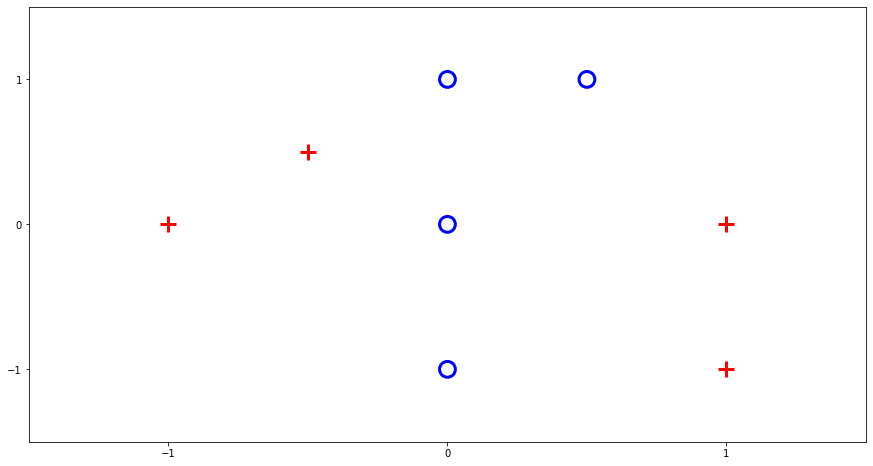

In [8]:
fig = plotit(df)

In order to determine the best stump to split on, we will use gini impurity on each feature column. Whichever column has the lowest gini score is the one in which the stump will be split on

In [9]:
score_x1, val_x1 = Gini_Index(df=df, col='x1', tar='y')
score_x2, val_x2 = Gini_Index(df=df, col='x2', tar='y')

print('Gini Score x1: {}\t Value: {}'.format(score_x1, val_x1))
print('Gini Score x2: {}\t Value: {}'.format(score_x2, val_x2))

Gini Score x1: 0.33333777777037027	 Value: -0.25
Gini Score x2: 0.33333777777037027	 Value: 1.0


We can see from both gini scores, splitting on x1 at -0.25 will produce a more pure child. Therefore, we will pick x1 as the stump being split on the value -0.25.

$$
 \begin{cases} 
      1 & x1 < -0.25 \\
      -1 & x1 \geq -0.25
   \end{cases}
$$

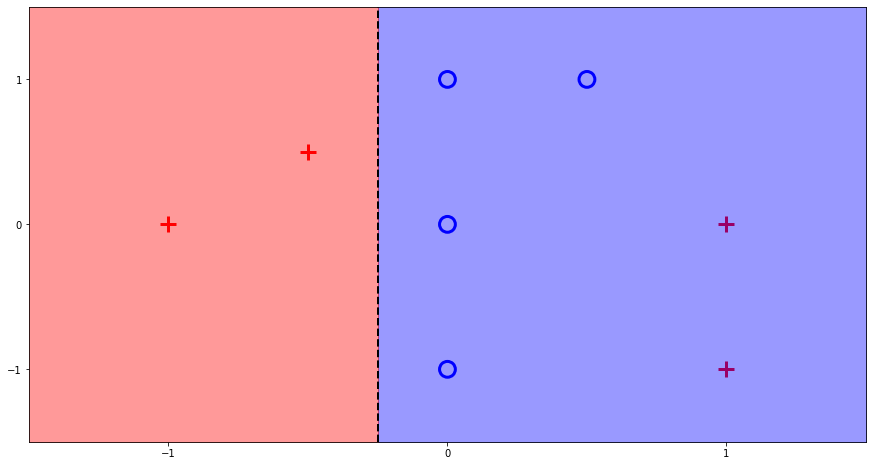

In [10]:
fig = plotit(df, show=False)
ax = fig.gca()
ax.plot([-0.25]*100, np.linspace(-1.5, 1.5, 100), ls='--', color='k', lw=2)
ax.fill_between(x=np.linspace(-0.25,1.5,100), y1=[-1.5]*100, y2=[1.5]*100, where=(np.linspace(0,1.5,100)>=0), alpha=0.4, color='blue')
ax.fill_between(x=np.linspace(-1.5,-0.25,100), y1=[-1.5]*100, y2=[1.5]*100, where=(np.linspace(-1.5,0,100)<=0), alpha=0.4, color='red')
plt.savefig('first.png', bbox_layout='tight', bbox_inches='tight')
plt.show()

Next, we need to determine how much say this stump will have in the overall classification. We do this by accounting for the errors in the stump. This stump made 2 errors (1,-1) & (1,0). The observations of the two errors each have a weight of $\frac{1}{8}$

$$
\epsilon_1 = \frac{1}{8} + \frac{1}{8} = \frac{1}{4}
$$

Therefore

$$
\alpha_1 = \frac{1}{2}log\frac{1 - \epsilon_1}{\epsilon_1} = \frac{1}{2}log\frac{1 - 0.25}{0.25} = 0.5493
$$

Next we need to update and then normalize the weights for the next stump. The update is as follows


$$
D_t(1) *
 \begin{cases} 
      e^{-\alpha_1} & \text{if}\ \ \ y^i = h_t(x^i) \\
      e^{\alpha_1} & \text{if}\ \ \ y^i \neq h_t(x^i) \\
   \end{cases}
$$

The stump incorrectly classified the two points (1,-1) & (1,0). So they're update will be proportional to $exp\{\alpha_1\}$

In [11]:
alpha = 0.5493

#adjust weights for correct points
df.loc[:,'weights'][df.x1 != 1] = df.weights.values[df.x1 != 1] * np.e**(-alpha)

#adjust weights for incorrect points
df.loc[:, 'weights'][df.x1 == 1] = df.weights.values[df.x1 == 1] * np.e**(alpha)

df

,x1,x2,y,weights
0,-1.0,0.0,1,0.072169
1,-0.5,0.5,1,0.072169
2,0.0,1.0,-1,0.072169
3,0.5,1.0,-1,0.072169
4,1.0,0.0,1,0.216505
5,1.0,-1.0,1,0.216505
6,0.0,-1.0,-1,0.072169
7,0.0,0.0,-1,0.072169


Finally, we must normalize all the newly adjusted weights so they sum to 1:

$$
D^i = \frac{D^i}{Z_t}
$$

where

$$
Z_t = \sum_{i=1}^m D_t(i) * 
\begin{cases} 
      e^{-\alpha_1} & \text{if}\ \ \ y^i = h_t(x^i) \\
      e^{\alpha_1} & \text{if}\ \ \ y^i \neq h_t(x^i) \\
   \end{cases}
$$

is the sum of all the newly adjusted weights

In [12]:
Z = df.weights.sum(axis=0)
print('Z =', Z)

Z = 0.8660254038007861


In [13]:
df.weights = df.weights / Z
df

,x1,x2,y,weights
0,-1.0,0.0,1,0.083334
1,-0.5,0.5,1,0.083334
2,0.0,1.0,-1,0.083334
3,0.5,1.0,-1,0.083334
4,1.0,0.0,1,0.249998
5,1.0,-1.0,1,0.249998
6,0.0,-1.0,-1,0.083334
7,0.0,0.0,-1,0.083334


| t | $\epsilon_t$ | $\alpha_t$ | $Z_t$ | $D_t(1)$ | $D_t(2)$ | $D_t(3)$ | $D_t(4)$ | $D_t(5)$ | $D_t(6)$ | $D_t(7)$ | $D_t(8)$ |
|---|--------------|------------|-------|----------|----------|----------|----------|----------|----------|----------|----------|
| 1 | 0.25         | 0.5493     | 0.866 | 0.083334 | 0.083334 | 0.083334 | 0.083334 | 0.249998 | 0.249998 | 0.083334 | 0.083334 |
| 2 |              |            |       |          |          |          |          |          |          |          |          |
| 3 |              |            |       |          |          |          |          |          |          |          |          |


Next, we need to randomly sample the original dataset with respect to their new weights so that we create a new training set of same size as the original. Since there are 8 samples, we will sample a unifomr [0,1] distribution 8 times. In order to determine which observation is added to the new dataset from these sampled numbers, we will take the cumsum of the weights

In [14]:
cumsum = df.weights.cumsum()
cumsum

0    0.083334
1    0.166668
2    0.250002
3    0.333335
4    0.583334
5    0.833332
6    0.916666
7    1.000000
Name: weights, dtype: float64

If a randomly sampled number is $0 \leq x \leq 0.083334$ then we add the first observation to the new dataset. If a randomly sampled number is $0.083334 < x \leq 0.166668$, then we add the second observation to the new dataset. If a randomly sampled number is $0.333335 < x \leq 0.584443$, then we add the $4^{th}$ observation to the new dataset. Etc, etc.

In [15]:
randoms = np.random.uniform(size=8)
randoms

array([0.9600173 , 0.69951205, 0.99986729, 0.2200673 , 0.36105635,
       0.73984099, 0.99645573, 0.31634698])

In [16]:
sampled_indices = [np.argmin(cumsum[cumsum > x]) for x in randoms]
sampled_indices

[7, 5, 7, 2, 4, 5, 7, 3]

So we can see for the next data set, observations 4 and 5, which were incorrectly classified in the first stump, make up 3 out of the 8 new samples for the next stump. Fortunately pandas already has a built in method to handle this sampling operation. So for simplicity, let's utilize that

In [17]:
df2 = df.sample(n=8, replace=True, weights=df.weights)
df2

,x1,x2,y,weights
1,-0.5,0.5,1,0.083334
4,1.0,0.0,1,0.249998
3,0.5,1.0,-1,0.083334
4,1.0,0.0,1,0.249998
5,1.0,-1.0,1,0.249998
6,0.0,-1.0,-1,0.083334
4,1.0,0.0,1,0.249998
2,0.0,1.0,-1,0.083334


Next, since we sampled a new dataset, we need to reset the weights, and then perform all the same steps as earlier

In [18]:
df2.weights = 1/8

In [19]:
#get gini scores for stump split
score_x1, val_x1 = Gini_Index(df=df2, col='x1', tar='y')
score_x2, val_x2 = Gini_Index(df=df2, col='x2', tar='y')

print('Gini Score x1: {}\t Value: {}'.format(score_x1, val_x1))
print('Gini Score x2: {}\t Value: {}'.format(score_x2, val_x2))

Gini Score x1: 0.18750453124492172	 Value: 0.75
Gini Score x2: 0.20833798610335644	 Value: 1.0


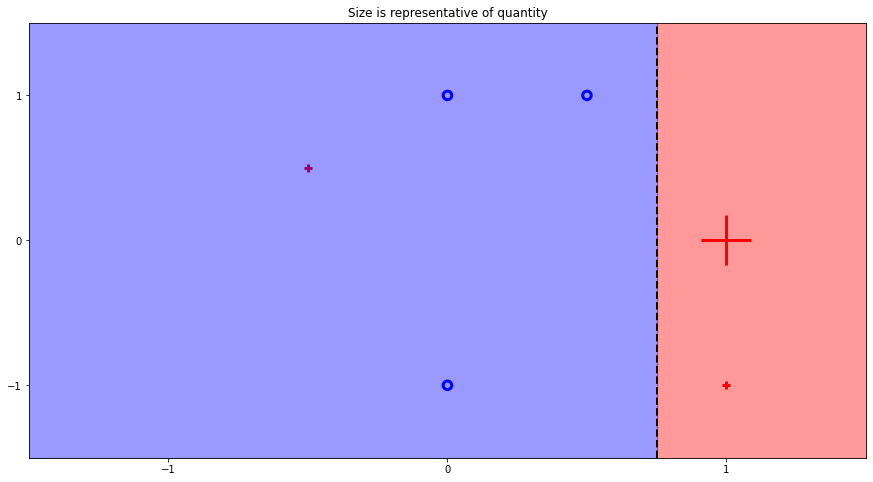

In [49]:
fig = plotit(df2, show=False, resized=True)
ax = fig.gca()
ax.plot([0.75]*100,np.linspace(-1.5, 1.5, 100),  ls='--', color='k', lw=2)
ax.fill_between(x=np.linspace(-1.5,0.75,100), y1=[-1.5]*100, y2=[1.5]*100, where=(np.linspace(0,1.5,100)>=0), alpha=0.4, color='blue')
ax.fill_between(x=np.linspace(0.75,1.5,100), y1=[-1.5]*100, y2=[1.5]*100, where=(np.linspace(-1.5,0,100)<=0), alpha=0.4, color='red')
plt.title('Size is representative of quantity')
plt.savefig('second.png', bbox_layout='tight', bbox_inches='tight')
plt.show()

In this instance, only one data point (-0.5 , 0.5) was misclassified. Thus:
$$
\epsilon_2 = \frac{1}{8}
$$

and

$$
\alpha_2 = \frac{1}{2}log\frac{1 - 0.125}{0.125} = 0.972955
$$

Adjusting the weights using $\alpha_2$ produces:

In [21]:
alpha = 0.972955

#adjust weights for incorrect points
df2.loc[:, 'weights'][(df2.x1==-0.5 )& (df2.x2==0.5)] = 0.125 * np.e**(alpha)

#adjust weights for correct points
df2.loc[:, 'weights'][~((df2.x1==-0.5 )& (df2.x2==0.5))] = 0.125 * np.e**(-alpha)

df2

,x1,x2,y,weights
1,-0.5,0.5,1,0.330719
4,1.0,0.0,1,0.047246
3,0.5,1.0,-1,0.047246
4,1.0,0.0,1,0.047246
5,1.0,-1.0,1,0.047246
6,0.0,-1.0,-1,0.047246
4,1.0,0.0,1,0.047246
2,0.0,1.0,-1,0.047246


Finally, normalizing all the newly adjusted weights produces

In [22]:
Z = df2.weights.sum(axis=0)
print('Z =', Z)

Z = 0.6614378277661495


In [23]:
df2.weights = df2.weights / Z
df2

,x1,x2,y,weights
1,-0.5,0.5,1,0.500000
4,1.0,0.0,1,0.071429
3,0.5,1.0,-1,0.071429
4,1.0,0.0,1,0.071429
5,1.0,-1.0,1,0.071429
6,0.0,-1.0,-1,0.071429
4,1.0,0.0,1,0.071429
2,0.0,1.0,-1,0.071429


| t | $\epsilon_t$ | $\alpha_t$ | $Z_t$  | $D_t(1)$ | $D_t(2)$ | $D_t(3)$ | $D_t(4)$ | $D_t(5)$ | $D_t(6)$ | $D_t(7)$ | $D_t(8)$ |
|---|--------------|------------|--------|----------|----------|----------|----------|----------|----------|----------|----------|
| 1 | 0.25         | 0.5493     | 0.866  | 0.083334 | 0.083334 | 0.083334 | 0.083334 | 0.249998 | 0.249998 | 0.083334 | 0.083334 |
| 2 | 0.125        | 0.972955   | 0.6614 | 0.5      | 0.071429 | 0.071429 | 0.071429 | 0.071429 | 0.071429 | 0.071429 | 0.071429 |
| 3 |              |            |        |          |          |          |          |          |          |          |          |

And Finally, repeating the same steps for the 3rd and final time

In [28]:
df3 = df2.sample(n=8, replace=True, weights=df2.weights)
df3.weights = 1/8
df3

,x1,x2,y,weights
1,-0.5,0.5,1,0.125
3,0.5,1.0,-1,0.125
1,-0.5,0.5,1,0.125
1,-0.5,0.5,1,0.125
1,-0.5,0.5,1,0.125
4,1.0,0.0,1,0.125
2,0.0,1.0,-1,0.125
1,-0.5,0.5,1,0.125


In [29]:
#get gini scores for stump split
score_x1, val_x1 = Gini_Index(df=df3, col='x1', tar='y')
score_x2, val_x2 = Gini_Index(df=df3, col='x2', tar='y')

print('Gini Score x1: {}\t Value: {}'.format(score_x1, val_x1))
print('Gini Score x2: {}\t Value: {}'.format(score_x2, val_x2))

Gini Score x1: 0.1666711111062962	 Value: -0.25
Gini Score x2: 4.999991666537677e-06	 Value: 1.0


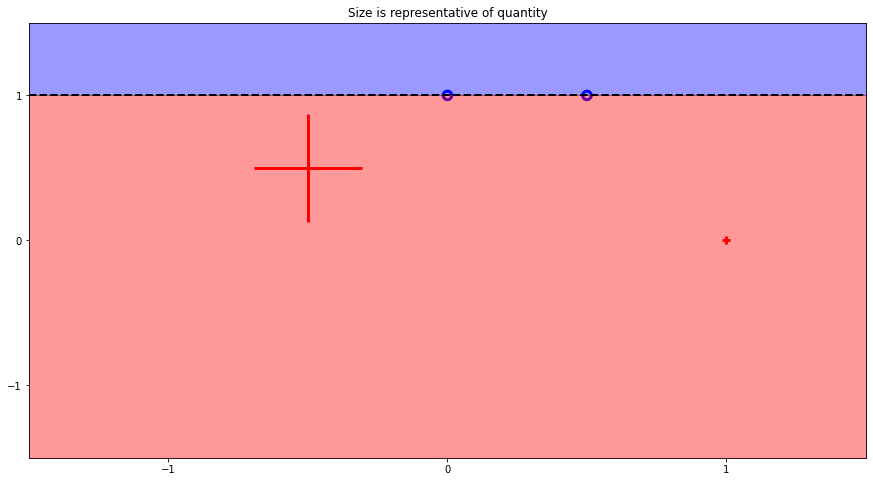

In [50]:
fig = plotit(df3, show=False, resized=True)
ax = fig.gca()
ax.plot(np.linspace(-1.5, 1.5, 100),[1]*100, ls='--', color='k', lw=2)
ax.fill_between(x=np.linspace(-1.5,1.5,100), y1=[1.0]*100, y2=[1.5]*100, where=(np.linspace(0,1.5,100)>=0), alpha=0.4, color='blue')
ax.fill_between(x=np.linspace(-1.5,1.5,100), y1=[-1.5]*100, y2=[1]*100, where=(np.linspace(-1.5,0,100)<=0), alpha=0.4, color='red')
plt.title('Size is representative of quantity')
plt.savefig('third.png', bbox_layout='tight', bbox_inches='tight')
plt.show()

There are 0 errors in this final iteration, therefore:

$$
\epsilon_3 = 0
$$

Since $\epsilon_3$ is 0, we will perturb it ever so slightly to not produce an error while calculating $\alpha_3$

$$
\alpha_3 =  \frac{1}{2}log\frac{1 - 0.00005}{0.00005} = 5.7564
$$

In [37]:
alpha = 5.7564

#adjust weights for correct points
df3.loc[:, 'weights'] = 0.125 * np.e**(-alpha)


In [38]:
Z = df3.weights.sum(axis=0)
print('Z =', Z)

Z = 0.003162476043927111


In [39]:
df3.weights = df3.weights / Z
df3

,x1,x2,y,weights
1,-0.5,0.5,1,0.125
3,0.5,1.0,-1,0.125
1,-0.5,0.5,1,0.125
1,-0.5,0.5,1,0.125
1,-0.5,0.5,1,0.125
4,1.0,0.0,1,0.125
2,0.0,1.0,-1,0.125
1,-0.5,0.5,1,0.125


| t | $\epsilon_t$ | $\alpha_t$ | $Z_t$   | $D_t(1)$ | $D_t(2)$ | $D_t(3)$ | $D_t(4)$ | $D_t(5)$ | $D_t(6)$ | $D_t(7)$ | $D_t(8)$ |
|---|--------------|------------|---------|----------|----------|----------|----------|----------|----------|----------|----------|
| 1 | 0.25         | 0.5493     | 0.866   | 0.083334 | 0.083334 | 0.083334 | 0.083334 | 0.249998 | 0.249998 | 0.083334 | 0.083334 |
| 2 | 0.125        | 0.972955   | 0.6614  | 0.5      | 0.071429 | 0.071429 | 0.071429 | 0.071429 | 0.071429 | 0.071429 | 0.071429 |
| 3 | 0            | 5.7564     | 0.00316 | 0.125    | 0.125    | 0.125    | 0.125    | 0.125    | 0.125    | 0.125    | 0.125    |

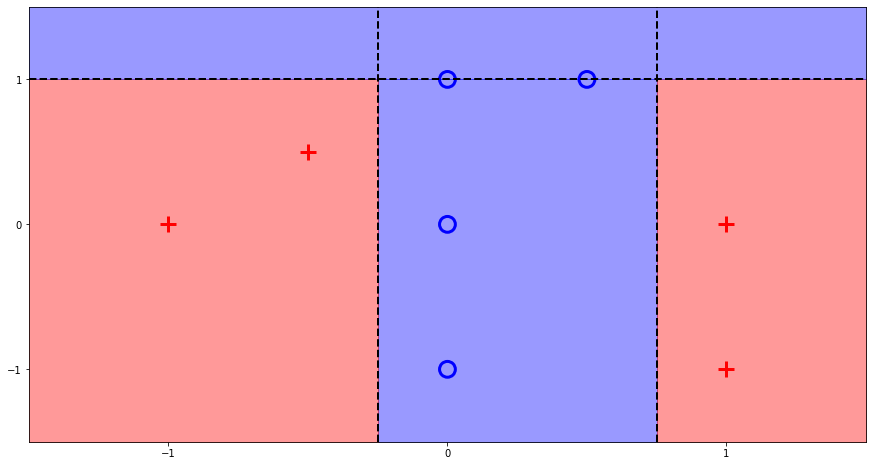

In [48]:
fig = plotit(df, show=False)
ax = fig.gca()
ax.plot([-0.25]*100, np.linspace(-1.5, 1.5, 100), ls='--', color='k', lw=2)
ax.plot(np.linspace(-1.5, 1.5, 100),[1.0]*100,  ls='--', color='k', lw=2)
ax.plot([0.75]*100, np.linspace(-1.5, 1.5, 100), ls='--', color='k', lw=2)
ax.fill_between(x=np.linspace(-0.25,0.75,100), y1=[-1.5]*100, y2=[1.0]*100, where=(np.linspace(0,1.5,100)>=0), alpha=0.4, color='blue')
ax.fill_between(x=np.linspace(-1.5,-0.25,100), y1=[-1.5]*100, y2=[1.0]*100, where=(np.linspace(-1.5,0,100)<=0), alpha=0.4, color='red')
ax.fill_between(x=np.linspace(0.75,1.5,100), y1=[-1.5]*100, y2=[1.0]*100, where=(np.linspace(0,1.5,100)>=0), alpha=0.4, color='red')
ax.fill_between(x=np.linspace(-1.5,1.5,100), y1=[1.0]*100, y2=[1.5]*100, where=(np.linspace(0,1.5,100)>=0), alpha=0.4, color='blue')
plt.savefig('final.png', bbox_layout='tight', bbox_inches='tight')
plt.show()

#### (b) What is the training error of this AdaBoost? Give a short explanation for why AdaBoost outperforms a single decision stump.

The training error for this data is 0. It manages to perfectly classify each observation. AdaBoost outperforms a single stump because it is a superposition of many "focused" stumps. Focused meaning each stump was explicitly directed to focus on errors from a prior stump to make up for its inadequacies. 